# Predizione tempi di percorrenza per sentieri di montagna

L'obiettivo di questo progetto è riuscire a predire il tempo di percorrenza di un sentiero di montagna basandosi su alcune caratteristiche del percorso.

Il [dataset utilizzato](https://www.kaggle.com/roccoli/gpx-hike-tracks) contiene 12141 percorsi registrati come **tracce GPX** ottenute dal sito [hikr.org](https://www.hikr.org/); oltre ai dati GPX (già semplificati per ridurne la dimensione), per ogni istanza sono presenti sia i dati del percorso (distanza, dislivello...) sia della registrazione (utente, data di registrazione...).

**Note**: è chiaro che il tempo di percorrenza dipenda anche da altre caratteristiche difficilmente registrabili o che comunque non siamo in grado di ottenere in questo caso, come il grado di allenamento del camminatore, la dimensione e peso dello zaino, il tipo di scarpe utilizzate (il tipo di suola della scarpa può influire notevolmente sulla velocità di camminata) e altri. Lo scopo del progetto è cercare di ottenere una predizione generale che possa rappresentare l'escursionista medio.

## Descrizione colonne

* **_id**: identificatore unico della traccia
* **user**: il nome dell'utente che ha caricato la traccia
* **name**: titolo assegnato alla traccia dall'autore
* **url**: URL alla pagina di hikr.org relativa alla traccia
* **start_time**: data e ora di inizio della registrazione
* **end_time**: data e ora di fine della registrazione
* **moving_time**: tempo, in secondi, per cui il registratore era in movimento; permette di escludere il tempo dedicato alle soste
* **max_speed**: indica la velocità massima ottenuta durante il percorso
* **length_2d**: lunghezza del percorso in metri senza considerare la variazioni in altitudine; è il valore che si ottiene misurando il percorso su una mappa
* **length_3d**: lunghezza del percorso in metri considerando anche la variazione di altitudine
* **max_elevation**: altitudine massima nell'intero percorso
* **min_elevation**: altitudine minima nell'intero percorso
* **uphill**: dislivello positivo percorso cumulativo, in metri
* **downhill**: dislivello negativo percorso cumulativo, in metri
* **difficulty**: un'indicazione della difficoltà del percorso secondo la [scala SAC](https://www.hikr.org/post17213.html) ([fonte originale](https://www.sac-cas.ch/fileadmin/Ausbildung_und_Wissen/Tourenplanung/Schwierigkeitsskala/Wanderskala-SAC.pdf) in tedesco)
* **bounds**: coordinate GPS dei vertici del rettangolo minimo che racchiude la traccia
* **gpx**: i dati GPX della traccia

Le colonne sicuramente interessanti sono **moving_time**, **length_2d**, **max_elevation**, **min_elevation**, **uphill**, **downhill**, **difficulty**; questi sono dati che possono essere ottenuti facilmente da una mappa o dalla descrizione di un percorso prima di percorrerlo (mentre ad esempio **length_3d** no).

Il campo **bounds** potrebbe essere interessante per individuare la zona del mondo in cui si è svolto il percorso.

## Problemi nei dati

1. **moving_time**: 2349 istanze hanno valore 0: possiamo cercare di recuperare il dato usando la differenza tra **end_time** e **start_time** (ovvero come se non fosse stata fatta nessuna pausa durante il percorso; questo approccio permette di sistemare solamente 6 istanze. Le altre devono essere scartate dato che questo è un dato indispensabile per il risultato che si vuole ottenere. Infine verifichiamo che la velocità media sia sensata, scartando tutte le righe in cui essa è superiore a 15km/h (velocità comunque estremamente difficile da raggiungere).
* **length_2d**: delle istanze rimanenti, 34 hanno valore minore di 1000; è probabile che un percorso tanto breve risulti inutile o fuorviante, quindi si sceglie di scartarle
* Per quanto riguarda le misure di altitudine (**max_elevation**, **min_elevation**, **uphill**, **downhill**), visto che i dati sono molto sporchi, si è scelto di ricalcolarle completamente a partire dalle tracce GPX; in generale i dati di altitudine ottenuti tramite GPS sono [poco affidabili](https://en.wikipedia.org/wiki/Altimeter#Global_Positioning_System), ma a partire dalle coordinate geografiche di ogni punto della traccia è possibile ottenere l'altitudine tramite vari servizi che si basano su mappe precalcolate.  
In questo caso verranno usati i dati della missione [SRTM](https://www2.jpl.nasa.gov/srtm/) della NASA, accessibili e utilizzabili tramite le librerie Python [gpxpy](https://pypi.org/project/gpxpy/) e [srtm.py](https://github.com/tkrajina/srtm.py). Purtroppo il dataset SRTM non ha dati per le latitudini vicine ai poli, quindi alcune tracce (51) devono essere lasciate intoccate. Le tracce per le quali non si riesce a ottenere l'altirudine di tutti i punti vengono eliminate.
* **difficulty** contiene solamente delle stringhe; è necessario convertirlo in un campo categorico ordinato. Oltre ai sei livelli _"ufficiali"_ della scala SAC, nel dataset ogni livello si trova anche variato con un `+` o `-`

Una volta applicate le modifiche precedenti rimangono **9679 istanze**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from ipywidgets import interact

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, \
    FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import zscore, pearsonr

Se necessario il dataset viene scaricato e le trasformazioni descritte sopra vengono applicate. Il risultato viene poi salvato in un file dedicato in formato Pickle.  
**NB**: in questa fase vengono scaricati e salvati i dati SRTM nella cartella locale `srtm_cache`; essa può crescere molto per cui è una buona idea cancellarla dopo averla utilizzata.

In [3]:
from utils import *
prepare_data()

I dati preprocessati vengono caricati e vengono rimosse tutti gli attributi inutilizzati. Inoltre la colonna `moving_time`, che è di tipo `timedelta`, viene convertita in `moving_minutes` che contiene i minuti che rappresentano l'intervallo temporale (in questo caso misurare la durata in minuti fornisce una precisione più che sufficiente).

In [4]:
data = pd.read_pickle(DATA_FILE)
data['moving_minutes'] = data['moving_time'] / timedelta(minutes=1)
used_cols = ['moving_minutes', 'length_2d', 'max_elevation', 'min_elevation', 'uphill', 'downhill', 'difficulty']
to_remove = set(data.columns) - set(used_cols)
data.drop(columns=to_remove, inplace=True)

### Variabili ordinali

È importante convertire l'attributo `difficulty`, che è di tipo _ordinale_ : leggendo le descrizioni dei diversi livelli della scala forniti da SAC è possibile dedurre che la difficoltà aumenta in modo quadratico con il livello. In questo modo è possibile dare un significato **quantitativo** alla difficoltà di un percorso. Altrimenti sarebbe stato possibile convertirlo in codifica _one-hot_ .

In [5]:
data['difficulty'] = data['difficulty'].factorize(sort=True)[0]**2

## Analisi dei dati
A giudicare dai grafici, in particolare i _Box Plot_ , si può notare l'elevata presenza di outliers; in questo caso però i dati sono verosimili ed è improbabile che derivino da errori (di qualsiasi tipo): sono semplicemente percorsi particolarmente impegnativi che vengono quindi effettuati molto di rado. Si è scelto dunque di mantenerli dato che contengono comunque informazioni utili. L'unico percorso che si decide di eliminare è quello con valori di `uphill` e `downhill` superiori a $25000$, in quanto potrebbe creare seri problemi numerici più avanti.

,downhill,uphill,length_2d,max_elevation,min_elevation,moving_minutes
count,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000
mean,976.670231,1034.208396,14326.546052,1925.192095,1027.342256,267.889684
std,736.931095,715.459755,11129.926875,755.533204,569.018297,180.225887
min,0.000000,0.000000,1002.181911,2.000000,-91.000000,12.983333
25%,554.260456,638.251488,9075.881552,1400.000000,584.000000,174.641667
50%,930.098490,977.020195,12575.356514,1967.333333,974.000000,251.416667
75%,1319.202070,1333.992000,17036.020433,2461.074052,1399.658499,331.300000
max,26565.667000,29286.167000,226907.816848,5604.216189,4191.000000,3156.333333


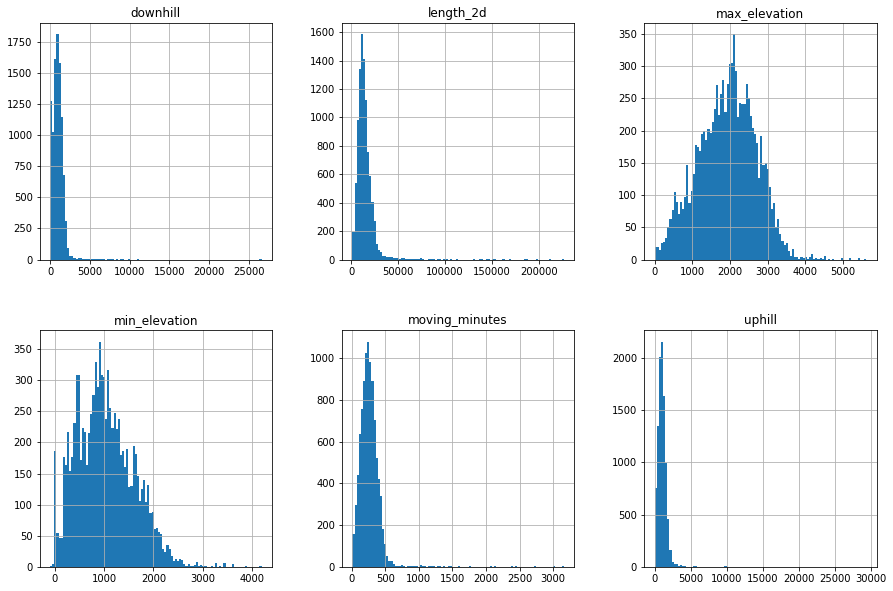

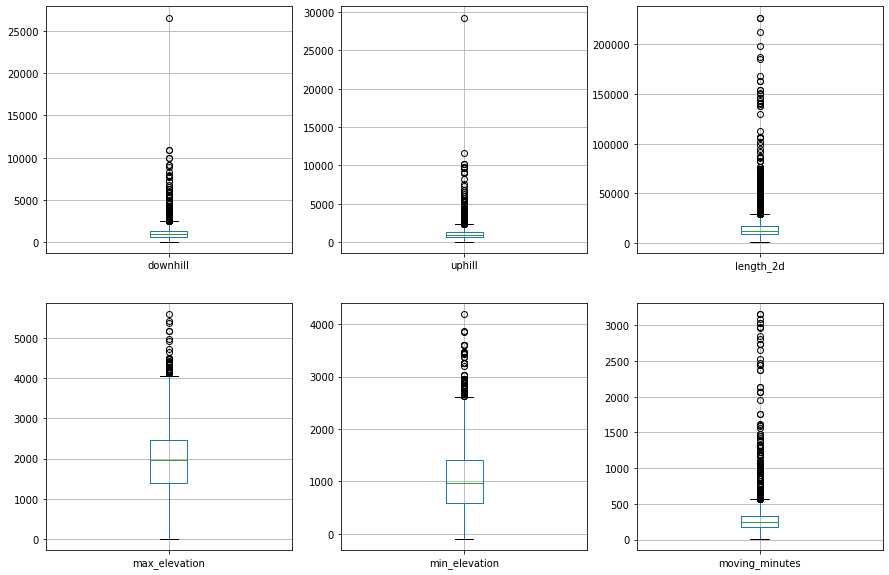

In [6]:
cols = ['downhill', 'uphill', 'length_2d', 'max_elevation', 'min_elevation', 'moving_minutes']
# Descrizione dei dati
display(data[cols].describe())

# Istogrammi
data[cols].hist(bins=100, figsize=(15,10), layout=(2, 3));

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for ax, col in zip(axes.flat, cols):
    data[[col]].boxplot(ax=ax);

In [7]:
drop_where(data, data['uphill'] > 25000)

## Correlazioni tra i dati
Nella tabella seguente sono presenti i coefficienti di correlazione di Pearson tra ogni coppia di features; in verde sono evidenziati i valori superiori a $0.5$

In [8]:
correlation_all = pd.DataFrame(np.corrcoef(data, rowvar=False) , index=data.columns, columns=data.columns)
mask = (correlation_all.abs() > 0.5) & ~np.eye(correlation_all.shape[0]).astype(bool)
correlation_all.style.apply(highlight_where(mask, color='lightgreen'))

,max_elevation,uphill,difficulty,min_elevation,downhill,length_2d,moving_minutes
max_elevation,1.000000,0.454901,0.256113,0.799747,0.396441,0.103687,0.253641
uphill,0.454901,1.000000,0.148876,-0.007344,0.851035,0.718694,0.805402
difficulty,0.256113,0.148876,1.000000,0.152722,0.122284,-0.020220,-0.002161
min_elevation,0.799747,-0.007344,0.152722,1.000000,-0.015095,-0.152831,-0.050318
downhill,0.396441,0.851035,0.122284,-0.015095,1.000000,0.735260,0.818772
length_2d,0.103687,0.718694,-0.020220,-0.152831,0.735260,1.000000,0.869685
moving_minutes,0.253641,0.805402,-0.002161,-0.050318,0.818772,0.869685,1.000000


Si può vedere che `difficulty` non ha nessuna correlazione significativa con le altre feature; le altre correlazioni presenti sono spiegate di seguito

### Correlazione tra `uphill` e `downhill`
C'è una correlazione lineare tra queste due variabili, specialmente per valori più alti; per valori più bassi è più debole, ma comunque presente. Questo è dovuto probabilmente al fatto che molte volte si percorre un sentiero ad anello.

Indice di correlazione tra tutti i valori:		0.8510354000370152
Indice di correlazione tra i valori minori di 2000:	0.7535933523097729


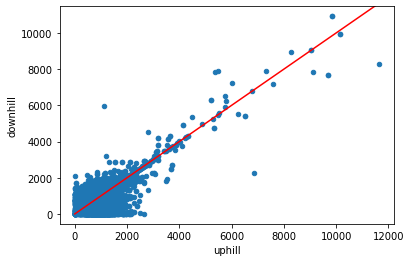

In [9]:
ax = data.plot.scatter('uphill', 'downhill')
ax.plot([0,30000], [0, 30000], scalex=False, scaley=False, c='red');
corr_all = np.corrcoef(data['uphill'], data['downhill'])[0,1]
small = data[(data['uphill'] <= 2000) & (data['downhill'] <= 2000)]
corr_small = np.corrcoef(small['uphill'], small['downhill'])[0,1]

print(f'Indice di correlazione tra tutti i valori:\t\t{corr_all}')
print(f'Indice di correlazione tra i valori minori di 2000:\t{corr_small}')

### Correlazione tra `min_elevation` e `max_elevation`
Anche tra queste due variabili è presente un certo grado di correlazione lineare; ovviamente l'altitudine massima sarà sempre maggiore della minima. Dal primo grafico si può vedere che i dati sono distribuiti in modo abbastanza simmetrico attorno alla diagonale traslata verso l'alto di 1000; il secondo grafico mostra che la differenza tra altitudine massima e minima può essere approssimata con una gaussiana centrata in 1000 (prevedibile dai grafici della sezione precedente, in cui `min_elevation` e `max_elevation` hanno una distribuzione simile alla gaussiana, la prima centrata in 1000 e la seconda centrata in 2000).

Indice di correlazione:	0.7997471217097558


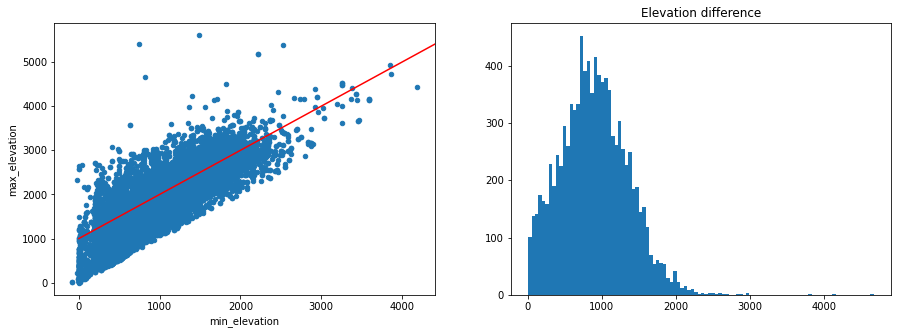

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
data.plot.scatter('min_elevation', 'max_elevation', ax=axes[0])
axes[0].plot([0,20000], [1000, 21000], scalex=False, scaley=False, c='red');
corr_all = np.corrcoef(data['min_elevation'], data['max_elevation'])[0,1]

elevation_diff = data['max_elevation'] - data['min_elevation']
axes[1].hist(elevation_diff, bins=100);
axes[1].set_title("Elevation difference")

print(f'Indice di correlazione:\t{corr_all}')

### Correlazione tra `uphill`/`downhill` e `length_2d`
Come si puo vedere sono presenti correlazioni abbastanza forti tra `uphill` e `length_2d` e tra `downhill` e `length_2d`. Questo è plausibile dato che percorrendo un percorso più lungo è probabile aver percorso anche più dislivello. Per cercare di rimuovere questa correlazione si può provare a dividere i valori di `uphill` e `downhill` per il valore di `length_2d`; questa soluzione sarà esplorata in seguito.

Indice di correlazione tra uphill e length_2d:	0.7186942444235986
Indice di correlazione tra dowhill e length_2d:	0.7352604059595419


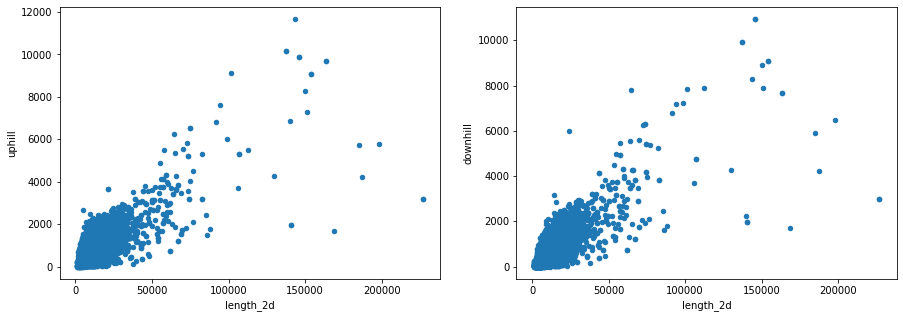

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
data.plot.scatter('length_2d', 'uphill', ax=axes[0])
corr_uphill = np.corrcoef(data['uphill'], data['length_2d'])[0,1]

data.plot.scatter('length_2d', 'downhill', ax=axes[1])
corr_downhill = np.corrcoef(data['downhill'], data['length_2d'])[0,1]

print(f'Indice di correlazione tra uphill e length_2d:\t{corr_uphill}')
print(f'Indice di correlazione tra dowhill e length_2d:\t{corr_downhill}')

Indice di correlazione tra uphill (normalizzato) e length_2d:	-0.23544417950165158
Indice di correlazione tra dowhill (normalizzato) e length_2d:	-0.05397845516784766
Indice di correlazione tra uphill (normalizzato) e moving_minutes:	-0.10532967769120116
Indice di correlazione tra downhill (normalizzato) e moving_minutes:	0.10173052064887235


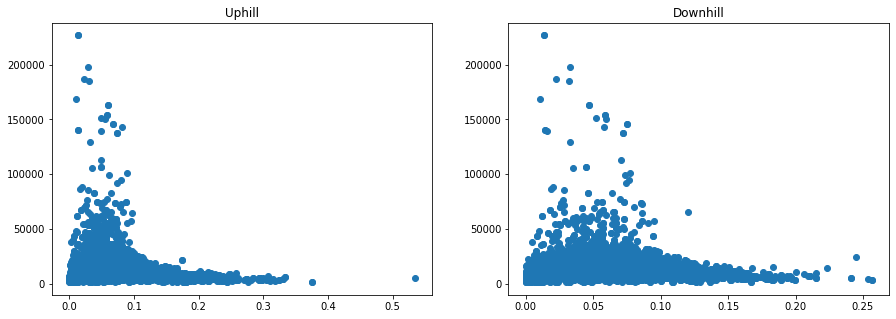

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
norm_uphill = data['uphill'] / data['length_2d']
axes[0].scatter(norm_uphill, data['length_2d'])
axes[0].set_title('Uphill')
corr_uphill = np.corrcoef(norm_uphill, data['length_2d'])[0,1]

norm_downhill = data['downhill'] / data['length_2d']
axes[1].scatter(norm_downhill, data['length_2d'])
axes[1].set_title('Downhill')
corr_downhill = np.corrcoef(norm_downhill, data['length_2d'])[0,1]

corr_uphill_time = np.corrcoef(norm_uphill, data['moving_minutes'])[0,1]
corr_downhill_time = np.corrcoef(norm_downhill, data['moving_minutes'])[0,1]

print(f'Indice di correlazione tra uphill (normalizzato) e length_2d:\t{corr_uphill}')
print(f'Indice di correlazione tra dowhill (normalizzato) e length_2d:\t{corr_downhill}')
print(f'Indice di correlazione tra uphill (normalizzato) e moving_minutes:\t{corr_uphill_time}')
print(f'Indice di correlazione tra downhill (normalizzato) e moving_minutes:\t{corr_downhill_time}')

Si può vedere che la correlazione è molto più bassa. Purtroppo è calata moltissimo anche la correlazione con `moving_minutes`

### Correlazioni con `moving_minutes`
Dai grafici si può notare che esiste una correlazione, seppur non forte, tra alcune variabili e il tempo in movimento. In particolare si può notare che `length_2d` è l'attributo con maggiore correlazione, mentre con `max_elevation`, `min_elevation` e `difficulty` sembra non esserci alcuna correlazione.

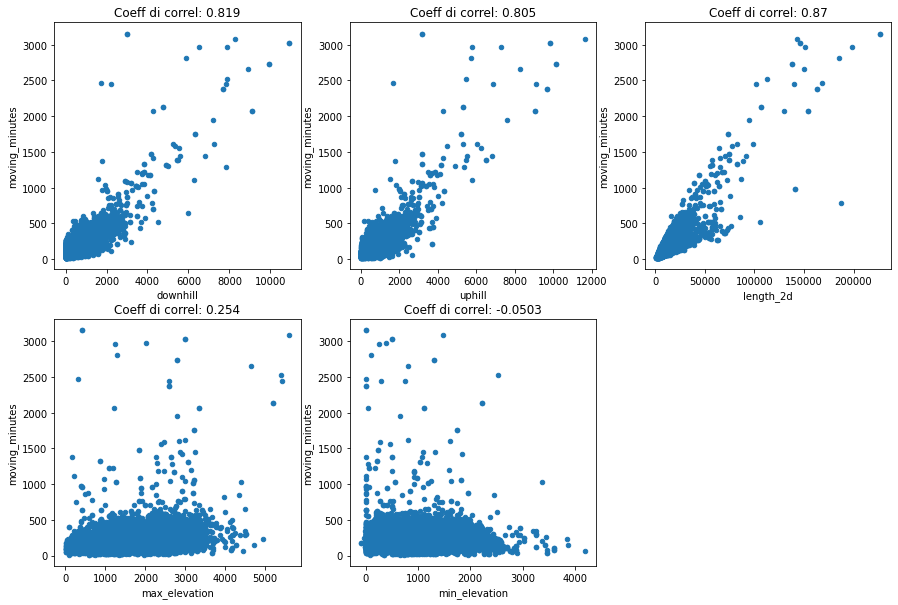

In [13]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
cols = ['downhill', 'uphill', 'length_2d', 'max_elevation', 'min_elevation']
for col, ax in zip(cols, axes.flat):
    correlation = np.corrcoef(data[col], data['moving_minutes'])[0,1]
    data.plot.scatter(col, 'moving_minutes', ax=ax, title=f"Coeff di correl: {correlation:.3}")
axes.flat[-1].axis('off');

## Preparazione del dataset

### Gestione degli outliers
Come visto in precedenza, nel dataset è presente un elevato numero di outliers; si è scelto di mantenerli dato che portano comunque informazioni utili allo scopo; nonostante ciò gli outlier più marcati vengono comunque rimossi dato che portano instabilità nell'apprendimento, a seconda che vengano inseriti nel _training_ o nel _validation set_. È comunque necessario considerare che anche quelli rimasti potrebbero creare problemi in particolare nel caso di una regressione polinomiale: anche dopo aver stardardizzato i dati (centrati in 0 e con deviazione standard 1) gli outlier possono avere valori molto grandi (in questo caso anche maggiori di 20), che vengono di molto amplificati aumentando il grado del polinomio.

In [14]:
# data_clean = data[(zscore(data) < 7).all(axis=1)].copy()
# print(f'Rimosse {len(data) - len(data_clean)} istanze')

In [15]:
data_clean = data.copy()

La variabile dipendente viene separata dalle altre

In [16]:
X_all = data_clean.copy()
y_all = X_all['moving_minutes']
X_all.drop(columns='moving_minutes', inplace=True)

In [17]:
def ds_split(X, y, **kwargs):
    '''Semplice funzione che suddivide il dataset in train e test set;
    utile per non ripetere sempre gli stessi parametri di `train_test_split`'''
    kwargs = {'random_state': 42, **kwargs}
    return train_test_split(X, y, test_size=1/3, shuffle=True, **kwargs)

## Features selection
I dati vengono standardizzati e successivamente viene utilizzato un modello di regressione lineare di tipo Lasso: in questo modo è possibile cercare di identificare le **variabili meno rilevanti** e quindi di semplificare il modello.

In [18]:
X_train, X_val, y_train, y_val = ds_split(X_all, y_all)

# Un semplice modello di regressione lineare che utilizza Lasso per selezionare le feature interessanti
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', Lasso(max_iter=1000))
])

def test_model(alpha):
    ''' Addestra il modello con il valore specificato di 'alpha'.
        Restituisce una serie con i coefficienti appresi e il coefficiente R2 del modello'''
    lasso_model.named_steps['linreg'].set_params(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    coeff = lasso_model.named_steps['linreg'].coef_
    r2 = lasso_model.score(X_val, y_val)
    return pd.Series(np.append(coeff, r2), index=alpha_test.index)

# Dataframe per contenere i risultati di vari test effettuati
alpha_test = pd.DataFrame([], index=np.append(X_train.columns, 'R2'))
alpha_test.columns.name = 'alpha'

alpha_values = [0.1, 2.7, 7.7, 10.5]
for a in alpha_values:
    alpha_test[a] = test_model(a)    
display(alpha_test.style.apply(highlight_zero))

alpha,0.1,2.7,7.7,10.5
max_elevation,-33.432519,-0.000000,0.000000,0.000000
uphill,59.878657,41.945119,38.937804,37.542695
difficulty,-9.902278,-7.722851,-1.307801,-0.000000
min_elevation,33.853518,5.273114,0.000000,0.000000
downhill,51.902145,44.968087,43.436169,42.386383
length_2d,78.812709,86.212956,83.963349,83.004440
R2,0.850517,0.848361,0.843540,0.841162


Nella tabella sono indicati i risultati con alcuni valori interessanti di $\alpha$: si vede che con $\alpha = 10.5$ si azzerano i coefficienti di **tre** attributi (`max_elevation`, `min_elevation`, `difficulty`), che risultano quindi inutilizzati; inoltre la variazione del coefficiente $R^2$ è molto piccola, passando da $0.805$ a $0.799$.  
Questo risultato indica che è possibile semplificare il modello, dimezzando il numero di attributi. In questo modo con un modello polinomiale ad esempio di grado 3, si passa da $(6+1)^3 = 343$ a $(3+1)^3 = 64$ parametri.

Di seguito si utilizza la class `LassoCV` che fa uso di _cross_validation_ (in questo caso a 5 fold) per determinare il miglior valore di $\alpha$. Il risultato conferma quanto ottenuto in precedenza, in cui i coefficienti di `max_elevation`, `min_elevation` e `difficulty` vengono azzerati.

In [19]:
X_train, X_val, y_train, y_val = ds_split(X_all, y_all)

# Regressione lineare usando Lasso per la normalizzazione
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LassoCV(eps=1e-1, cv=5))
])
lasso_model.fit(X_train, y_train)
print('Coefficiente R2: {}'.format(lasso_model.score(X_val, y_val)))
print('Valore di alpha: {}'.format(lasso_model.named_steps['linreg'].alpha_))
pd.DataFrame(lasso_model.named_steps['linreg'].coef_, index=X_train.columns, columns=['']).style.apply(highlight_zero)

Coefficiente R2: 0.836807720185167
Valore di alpha: 15.302112013888426


,
max_elevation,0.000000
uphill,35.794755
difficulty,-0.000000
min_elevation,0.000000
downhill,40.830776
length_2d,80.659788


_Ridge_ ottiene uno score leggermente maggiore utilizzando tutte le feature.

In [20]:
X_train, X_val, y_train, y_val = ds_split(X_all, y_all)

ridgecv_alphas = np.geomspace(0.1, 50, 100)

# Regressione lineare usando Ridge per la normalizzazione
ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', RidgeCV(alphas=ridgecv_alphas, cv=5))
])
ridge_model.fit(X_train, y_train)
print('Coefficiente R2: {}'.format(ridge_model.score(X_val, y_val)))
print('Valore di alpha: {}'.format(ridge_model.named_steps['linreg'].alpha_))
pd.DataFrame(ridge_model.named_steps['linreg'].coef_, index=X_train.columns, columns=[''])

Coefficiente R2: 0.8504187158740413
Valore di alpha: 49.99999999999999


,
max_elevation,-30.627880
uphill,58.410768
difficulty,-10.027768
min_elevation,31.494557
downhill,51.696797
length_2d,78.831143


Il dataset viene quindi semplificato rimuovendo le feature meno significative

In [21]:
X_tmp = X_all.copy()
X_tmp.drop(columns=['difficulty', 'min_elevation', 'max_elevation'], inplace=True)

Una parte del dataset viene ora salvata separatamente per essere utilizzata come _test set_ per verificare la validità del modello definitivo.

In [22]:
X, X_test, y, y_test = train_test_split(X_tmp, y_all, test_size=1/4, shuffle=True, random_state=42)

## Regressione lineare
Usando il dataset semplificato, viene costruito un modello di regressione lineare che utilizza _ElasticNet_ per la normalizzaione.  
Anche in questo caso viene usata _cross_validation_ a 5 fold per determinare i valori migliori degli iperparametri (`l1_ratio` e `alpha`).

Il risultato ottenuto è buono; si nota che viene usata principalmente una regressione di tipo _Lasso_ (con peso 0.88)

In [23]:
X_train, X_val, y_train, y_val = ds_split(X, y)

l1_ratio_values = np.geomspace(0.1, 1, 20)

linear_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', ElasticNetCV(cv=5, l1_ratio=l1_ratio_values))
])
linear_model.fit(X_train, y_train)
print('Coefficiente R2:', linear_model.score(X_val, y_val))
print('MSE:            ', mean_squared_error(y_val, linear_model.predict(X_val)))
print('Valore di alpha:', linear_model.named_steps['linreg'].alpha_)
print('L1 ratio:       ', linear_model.named_steps['linreg'].l1_ratio_)

Coefficiente R2: 0.7983609723871926
MSE:             4699.160886960218
Valore di alpha: 0.18239265905305233
L1 ratio:        0.8858667904100825


## Regressione polinomiale
Si cerca di utilizzare un modello di regressione polinomiale per meglio rappresentare i dati; anche in questo caso si fa uso di _grid search_ e _cross validation_ per determinare i valori degli iperparametri (il grado del polinomio oltre a quelli della regressione lineare).

Come spiegato in precedenza la presenza di outliers potrebbe portare a valori molto grandi nei fattori di grado alto: per questo i dati vengono riscalati dopo aver aggiunto le features polinomiali. La funzione di scaling da utilizzare è un iperparametro che viene scelto nella _grid search_ e include anche la possibilità di non applicare alcuno scaling.

In [24]:
%%time

# I warning di mancata convergenza vengono ignorati in quanti riempirebbero l'output.
# Se una combinazione di parametri evita la convergenza e porta a un risultato scadente,
# questa verrà automaticamente scartata dalla grid search
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X_train, X_val, y_train, y_val = ds_split(X, y)

l1_ratio_values = np.geomspace(0.5, 1, 10)

poly_model_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)), # L'intercetta viene trovata dalla reg lineare
    # Aumentando il grado del polinomio si potrebbero ottenere valori anche molto grandi
    ('scaler2', None),
    ('linreg', ElasticNetCV(cv=5, l1_ratio=l1_ratio_values, eps=1e-2))
])

params_grid = {
    'poly__degree': np.arange(2,6),
    'scaler2': [FunctionTransformer(), RobustScaler(), MinMaxScaler(), StandardScaler()]
}

poly_model = GridSearchCV(poly_model_estimator, params_grid, cv=5);
poly_model.fit(X_train, y_train);

CPU times: user 3min 34s, sys: 2min 41s, total: 6min 16s
Wall time: 1min 41s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('scaler2', None),
                                       ('linreg',
                                        ElasticNetCV(alphas=None, copy_X=True,
                                                     cv=5, eps=0.01,
                                                     

In [25]:
best_poly_model = poly_model.best_estimator_.named_steps['linreg']
print('Coefficiente R2:', poly_model.score(X_val, y_val))
print('MSE:            ', mean_squared_error(y_val, poly_model.predict(X_val)))
print('Iperparametri')
print('  - grado del polinomio:', poly_model.best_params_['poly__degree'])
print('  - standardizzazione:  ', poly_model.best_params_['scaler2'])
print('  - ElasticNet L1 ratio:', best_poly_model.l1_ratio_)
print('  - ElasticNet alpha:   ', best_poly_model.alpha_)

Coefficiente R2: 0.8021647824908115
MSE:             4610.5137839069685
Iperparametri
  - grado del polinomio: 2
  - standardizzazione:   MinMaxScaler(copy=True, feature_range=(0, 1))
  - ElasticNet L1 ratio: 1.0
  - ElasticNet alpha:    0.2480069316833537


Il risultato è paragonabile al precedente.

## Regressione polinomiale con kernel trick
Si utilizza il kernel trick per cercare di realizzare polinomi di grado superiore in tempo utile, nonostante comunque nel passaggio precedente dall'esecuzione della _grid search_ sia stato scelto un polinomio di secondo grado.

In [26]:
X_train, X_val, y_train, y_val = ds_split(X, y)

kernel_model_estimator = Pipeline([
    ('scaler', MinMaxScaler()),
    ('linreg', KernelRidge(kernel='polynomial'))
])
params_grid = [{
    'linreg__degree': np.arange(5, 10),
    'linreg__alpha': np.linspace(0.5, 5, 4)
},
{
    'linreg__degree': np.arange(10, 21, 2),
    'linreg__alpha': np.arange(5, 30, 5)
}]
kernel_model = GridSearchCV(kernel_model_estimator, params_grid, cv=5);
kernel_model.fit(X_train, y_train);

In [27]:
print('Coefficiente R2:', kernel_model.score(X_val, y_val))
print('MSE:            ', mean_squared_error(y_val, kernel_model.predict(X_val)))
print('Iperparametri')
print('  - grado del polinomio:', kernel_model.best_params_['linreg__degree'])
print('  - Ridge alpha:', kernel_model.best_params_['linreg__alpha'])

Coefficiente R2: 0.7958687044311343
MSE:             4757.2427386611835
Iperparametri
  - grado del polinomio: 5
  - Ridge alpha: 3.5


In effetti il risultato è poco peggiore del precedente.

## Radial Basis Gaussian Kernel
Infine viene testato un modello che utilizza il kernel trick con il **Gaussian Radial Basis** kernel. Il risultato però è insoddisfacente.

In [28]:
X_train, X_val, y_train, y_val = ds_split(X, y)

gaussian_model_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('gauss', GaussianProcessRegressor(n_restarts_optimizer=3))
])
params_grid = {
    'gauss__alpha': np.arange(0.1, 2.1, 0.2)
}
gaussian_model = GridSearchCV(gaussian_model_estimator, params_grid, cv=5)
gaussian_model.fit(X_train, y_train);

In [29]:
print('Coefficiente R2:', gaussian_model.score(X_val, y_val))
print('MSE:            ', mean_squared_error(y_val, gaussian_model.predict(X_val)))
print('Alpha:          ', gaussian_model.best_params_['gauss__alpha'])

Coefficiente R2: 0.65816378857761
MSE:             7966.43077225755
Alpha:           0.1


## Ricapitolando
Di seguito sono messi a confronto i modelli analizzati, verificandone la qualità utilizzando il **test set** determinato inizialmente.

In [30]:
models = [linear_model, poly_model, kernel_model, gaussian_model]
pd.DataFrame([[m.score(X_test, y_test), mean_squared_error(y_test, m.predict(X_test))] for m in models],
             index=['Lineare', 'Polinomiale', 'Kernel trick', 'Gaussian Radial Basis'],
             columns=['Coeff R2', 'MSE'])

,Coeff R2,MSE
Lineare,0.849154,5213.311748
Polinomiale,0.847290,5277.747791
Kernel trick,0.837677,5609.975708
Gaussian Radial Basis,0.525116,16412.230165


Si può notare che il risultato migliore si ottiene con il modello lineare. Di seguito sono visualizzati i coefficienti determinati durante l'apprendimento: `length_2d` ha il peso massimo, mentre `uphill` e `downhill` hanno peso simile. Sembra che il tempo sia influenzato maggiormente da `downhill` che `uphill` (forse andando in discesa si va più lenti?)

In [34]:
pd.DataFrame(linear_model.named_steps['linreg'].coef_, index=X.columns, columns=[''])

,
uphill,46.157714
downhill,48.130197
length_2d,88.110032


Infine il modello viene testato con alcuni sentieri percorsi personalmente.

In [40]:
my_data = pd.DataFrame([
    [367, 365, 11030, 123],
    [1261, 953, 11530, 262],
    [457, 703, 8100, 125]
], columns=['uphill', 'downhill', 'length_2d', 'moving_minutes'])
my_X = my_data.iloc[:, 0:-1]
my_y = my_data.iloc[:, -1]
y_pred = linear_model.predict(my_X)
display(pd.DataFrame([my_y, y_pred], index=['Reali', 'Predetti']))
print('MSE:', mean_squared_error(my_y, y_pred))
print('R2: ', linear_model.score(my_X, my_y))

,0,1,2
Reali,123.000000,262.000000,125.000000
Predetti,156.920603,260.341529,162.493614


MSE: 853.042968254727
R2:  0.7984620487664056


Possiamo vedere che il modello finale non è super accurato, ma comunque accettabile se lo scopo è quello di avere una previsione di massima del tempo di percorrenza.